In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd

import scipy.stats as stats

try:
    from rich import print
except Exception:
    pass


In [2]:
log_root_dir = "./log"
log_dirs = [
    os.path.join(log_root_dir, dir)
    for dir in os.listdir(log_root_dir)
    if not dir.startswith("archive") and os.path.isdir(os.path.join(log_root_dir, dir))
]
summary_paths = [os.path.join(log_dir, "summary.txt") for log_dir in log_dirs]
keys = [
    "CNN",
    "Adv",
    "Quant",
    "Reg",
    "Quant_Adv",
    "Quant_Reg",
    "Adv_Reg",
    "Quant_Adv_Reg",
    "RSE",
]
data_cols = [
    "Original accuracy",
    "Adversarial accuracy",
    "Adversarial success rate",
]


def parse_all_summaries(summary_paths):
    total_summary = {}
    total_summary["model"] = []
    total_summary["seed"] = []
    total_summary["epsilon"] = []
    for k in data_cols:
        total_summary[k] = []
    for file_path in summary_paths:
        with open(file_path, "r") as f:
            lines = f.readlines()
            idx = 0
            file_name = ""
            this_seed = 0
            this_epsilon = 0
            while not lines[idx].startswith("==>"):
                if lines[idx].startswith("SEED"):
                    this_seed = int(lines[idx].split("=")[1].strip())
                elif lines[idx].startswith("ATTACK_EPS"):
                    this_epsilon = int(lines[idx].split("=")[1].split("/")[0].strip())
                idx += 1
            for line in lines[idx:]:
                line = line.strip()
                if line.startswith("==>"):
                    file_name = line.replace("==>", "").replace("<==", "").strip()
                    file_name = os.path.basename(file_name)
                    file_name, _ = os.path.splitext(file_name)
                    file_name = file_name.replace("_Train", "").replace("Comb_", "")
                    total_summary["model"].append(file_name)
                    total_summary["seed"].append(this_seed)
                    total_summary["epsilon"].append(this_epsilon)
                elif len(line) < 1:
                    continue
                else:
                    line = line.replace("%", "")
                    key, value = line.split(" : ")
                    total_summary[key].append(float(value))
    return pd.DataFrame(total_summary)


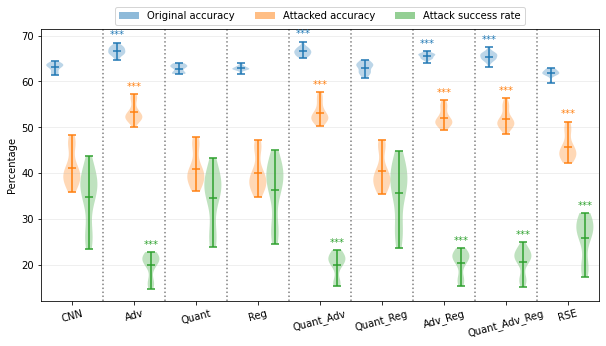

In [3]:
summaries = parse_all_summaries(summary_paths).sort_values(by="epsilon")

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
]

fig = plt.figure(figsize=(10, 5))
plt.tight_layout()
for idx in range(len(data_cols)):
    data = summaries.groupby("model")[data_cols[idx]].apply(list)[keys]
    plt.violinplot(
        data,
        widths=0.55,
        positions=2 * np.arange(len(keys)) + (idx - 1) * 0.55,
        bw_method="silverman",
        showmeans=True,
        showextrema=True,
    )
    test_mode = "less" if idx != 2 else "greater"
    _ = [
        plt.text(
            x,
            y,
            (
                ""
                if stats.ttest_rel(data.iloc[0], data.iloc[i], alternative=test_mode)[1]
                > 0.1
                or i == 0
                else "*"
                if stats.ttest_rel(data.iloc[0], data.iloc[i], alternative=test_mode)[1]
                > 0.05
                else "**"
                if stats.ttest_rel(data.iloc[0], data.iloc[i], alternative=test_mode)[1]
                > 0.01
                else "***"
            ),
            color=colors[idx],
            horizontalalignment="center",
        )
        for i, (x, y) in enumerate(
            zip(
                2 * np.arange(len(keys)) + (idx - 1) * 0.55,
                np.max(np.stack(data.values), axis=1) + 1,
            )
        )
    ]
plt.xticks(2 * np.arange(len(keys)), labels=keys, rotation=15)
plt.ylabel("Percentage")
plt.legend(
    handles=[
        Patch(facecolor="tab:blue", alpha=0.5, label="Original accuracy"),
        Patch(facecolor="tab:orange", alpha=0.5, label="Attacked accuracy"),
        Patch(facecolor="tab:green", alpha=0.5, label="Attack success rate"),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
)
plt.grid(axis="y", alpha=0.25)
_ = [
    plt.axvline(x=x, color="tab:grey", linestyle=":")
    for x in np.arange(len(keys) - 1) * 2 + 1
]
plt.xlim(-1, len(keys) * 2 - 1)
plt.savefig("./fig/Summary.pdf")
plt.show()


In [4]:
def parse_loss_history(dir_name):
    loss_history = {}
    loss_files = [
        os.path.join(dir_name, file_name)
        for file_name in os.listdir(dir_name)
        if file_name.endswith(".csv")
    ]
    for loss_file in loss_files:
        data = pd.read_csv(loss_file, index_col=0)
        file_name, _ = os.path.splitext(os.path.basename(loss_file))
        file_name = (
            file_name.replace("_Train", "")
            .replace("Comb_", "")
            .replace("_loss_history", "")
        )
        loss_history[file_name] = data.iloc[:, 0].values
    return loss_history


def parse_loss_histories(dir_name_list):
    total_loss_history = {}
    for dir_name in dir_name_list:
        loss_history = parse_loss_history(dir_name)
        for key in loss_history:
            if key not in total_loss_history:
                total_loss_history[key] = []
            total_loss_history[key].append(loss_history[key])
    for key in total_loss_history:
        total_loss_history[key] = np.stack(total_loss_history[key])
    return total_loss_history


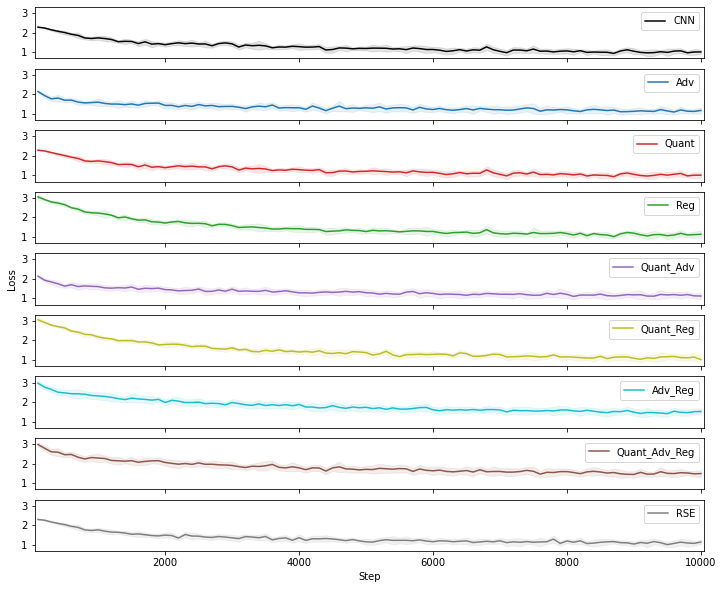

In [5]:
loss = parse_loss_histories(log_dirs)
colors = [
    "black",
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:purple",
    "tab:olive",
    "tab:cyan",
    "tab:brown",
    "tab:grey",
]

fig = plt.figure(figsize=(12, 10))
plt.tight_layout()
axs = fig.subplots(len(keys), 1, sharex=True, sharey=True)
for i, (k, ax) in enumerate(zip(keys, axs)):
    ax.plot(
        (np.arange(loss[k].shape[1]) + 1) * 100,
        loss[k].mean(axis=0),
        label=k,
        color=colors[i],
    )
    ax.fill_between(
        (np.arange(loss[k].shape[1]) + 1) * 100,
        loss[k].mean(axis=0) - loss[k].std(axis=0),
        loss[k].mean(axis=0) + loss[k].std(axis=0),
        alpha=0.1,
        color=colors[i],
    )
    if i == len(keys) // 2:
        ax.set_ylabel("Loss")
    ax.legend()
plt.xlabel("Step")
plt.xlim(50, loss[k].shape[1] * 100 + 50)
plt.savefig("./fig/Loss.pdf")
plt.show()


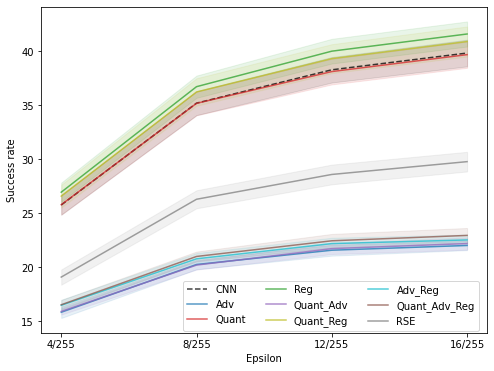

In [6]:
epsilons = sorted(summaries["epsilon"].unique().tolist())
success_rates_mean = (
    summaries.groupby(["model", "epsilon"])[data_cols[-1]]
    .mean()[keys]
    .values.reshape(-1, len(epsilons))
)
success_rates_std = (
    summaries.groupby(["model", "epsilon"])[data_cols[-1]]
    .std()[keys]
    .values.reshape(-1, len(epsilons))
)

fig = plt.figure(figsize=(8, 6))
plt.tight_layout()
for i in range(len(keys)):
    plt.plot(
        epsilons,
        success_rates_mean[i],
        label=keys[i],
        color=colors[i],
        alpha=0.75,
        linestyle="-" if i else "--",
    )
    plt.fill_between(
        epsilons,
        success_rates_mean[i] - np.log(success_rates_std[i] + 1),
        success_rates_mean[i] + np.log(success_rates_std[i] + 1),
        color=colors[i],
        alpha=0.1,
    )
plt.legend(bbox_to_anchor=(0.65, 0.175), ncol=3, loc="upper center")
plt.xticks(epsilons, labels=[f"{eps}/255" for eps in epsilons])
plt.xlabel("Epsilon")
plt.ylabel("Success rate")
plt.savefig("./fig/Success_rate.pdf")
plt.show()


In [7]:
print(
    summaries.set_index(["model", "seed", "epsilon"])
    .groupby(["model", "epsilon"])
    .describe(percentiles=[0.5])
)


Original accuracy                                   \
                                  count    mean       std    min     50%   
model         epsilon                                                      
Adv           4                    10.0  67.065  0.814906  65.93  67.160   
              8                    10.0  66.598  0.887391  64.93  66.600   
              12                   10.0  66.388  1.007007  64.61  66.225   
              16                   10.0  66.343  1.017721  64.57  66.405   
Adv_Reg       4                    10.0  65.680  0.625922  64.67  65.915   
              8                    10.0  65.816  0.635578  64.54  65.935   
              12                   10.0  65.486  0.437396  64.84  65.540   
              16                   10.0  65.252  0.576518  64.10  65.250   
CNN           4                    10.0  63.054  0.984786  61.31  63.365   
              8                    10.0  63.054  0.984786  61.31  63.365   
              12                   10.0  63.054  0.984786  61.31  63.365   
              16                   10.0  63.054  0.984786  61.31  63.365   
Quant         4                    10.0  62.805  0.890920  61.65  63.100   
              8                    10.0  62.805  0.890920  61.65  63.100   
              12                   10.0  62.805  0.890920  61.65  63.100   
              16                   10.0  62.805  0.890920  61.65  63.100   
Quant_Adv     4                    10.0  67.131  1.062695  65.54  67.085   
              8                    10.0  66.583  0.705424  65.55  66.430   
              12                   10.0  66.314  0.692198  65.33  66.270   
              16                   10.0  66.092  0.743935  65.05  66.020   
Quant_Adv_Reg 4                    10.0  65.884  0.796453  64.61  65.820   
              8                    10.0  65.487  0.723941  64.34  65.520   
              12                   10.0  65.404  0.887383  63.96  65.275   
              16                   10.0  64.950  0.992662  63.08  64.910   
Quant_Reg     4                    10.0  62.954  1.226188  60.81  63.275   
              8                    10.0  62.954  1.226188  60.81  63.275   
              12                   10.0  62.954  1.226188  60.81  63.275   
              16                   10.0  62.954  1.226188  60.81  63.275   
RSE           4                    10.0  61.716  0.865861  59.70  61.820   
              8                    10.0  61.823  0.898703  59.67  61.825   
              12                   10.0  61.823  0.898703  59.67  61.825   
              16                   10.0  61.823  0.898703  59.67  61.825   
Reg           4                    10.0  62.851  0.586618  61.71  62.760   
              8                    10.0  62.851  0.586618  61.71  62.760   
              12                   10.0  62.851  0.586618  61.71  62.760   
              16                   10.0  62.851  0.586618  61.71  62.760   

                             Adversarial accuracy                           \
                         max                count    mean       std    min   
model         epsilon                                                        
Adv           4        68.42                 10.0  56.441  0.599471  55.15   
              8        67.82                 10.0  53.106  0.696247  52.04   
              12       67.92                 10.0  52.061  0.610782  50.75   
              16       67.83                 10.0  51.734  0.708632  50.14   
Adv_Reg       4        66.54                 10.0  54.855  0.616212  53.95   
              8        66.66                 10.0  52.140  0.638436  51.35   
              12       66.14                 10.0  50.954  0.540395  50.16   
              16       66.06                 10.0  50.552  0.649646  49.37   
CNN           4        64.36                 10.0  46.803  0.875659  45.67   
              8        64.36                 10.0  40.864  1.222895  39.17   
              12       64.36               

In [8]:
if not os.path.exists("./fig/PGD"):
    os.mkdir("./fig/PGD")

for dir_name in log_dirs:
    os.system(
        f"cp {os.path.join(dir_name, 'PGD.pdf')} ./fig/PGD/{os.path.basename(dir_name)}_PGD.pdf"
    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


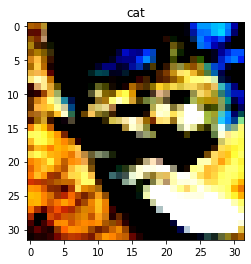

In [37]:
from utils import get_test_dataloader, DEVICE, class_labels

test_dataset = get_test_dataloader(1, True)
image, label = next(iter(test_dataset))
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.title(class_labels[label.item()])
plt.show()


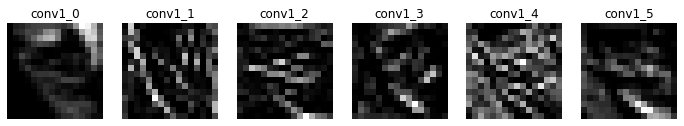

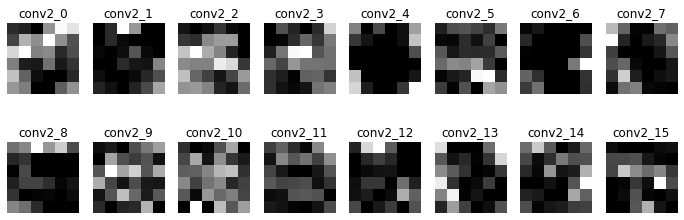

In [54]:
import torch
from CNN import CNN

model = CNN().to(DEVICE)
model.load_state_dict(torch.load("./model/CNN.ckpt", map_location=DEVICE))
model.eval()
conv1_result = model.conv1(image.to(DEVICE))
conv2_result = model.conv2(conv1_result)

fig = plt.figure(figsize=(12, 2))
for i in range(conv1_result.shape[1]):
    ax = fig.add_subplot(1, conv1_result.shape[1], i + 1)
    ax.imshow(conv1_result[0, i, :, :].cpu().detach().numpy(), cmap="gray")
    ax.set_title(f"conv1_{i}")
    ax.axis("off")
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.tight_layout()
for i in range(conv2_result.shape[1]):
    ax = fig.add_subplot(2, conv2_result.shape[1] // 2, i + 1)
    ax.imshow(conv2_result[0, i, :, :].cpu().detach().numpy(), cmap="gray")
    ax.set_title(f"conv2_{i}")
    ax.axis("off")
plt.show()


In [70]:
import torch


def visualize_model(model, input, title, save_path=None):
    output1 = model.conv1(input)
    output2 = model.conv2(output1)
    fig = plt.figure(figsize=(9, 6), constrained_layout=True)
    plt.tight_layout()
    fig.suptitle(title)
    subfigs = fig.subfigures(3, 1, hspace=0.1, height_ratios=[4, 2, 3])

    for i in range(input.shape[1]):
        ax = subfigs[0].add_subplot(1, input.shape[1], i + 1)
        ax.imshow(input[0, i, :, :].cpu().detach().numpy(), cmap="gray")
        ax.set_title(f"input_{i}")
        ax.axis("off")
    for i in range(output1.shape[1]):
        ax = subfigs[1].add_subplot(1, output1.shape[1], i + 1)
        ax.imshow(output1[0, i, :, :].cpu().detach().numpy(), cmap="gray")
        ax.set_title(f"conv1_{i}")
        ax.axis("off")
    for i in range(output2.shape[1]):
        ax = subfigs[2].add_subplot(2, output2.shape[1] // 2, i + 1)
        ax.imshow(output2[0, i, :, :].cpu().detach().numpy(), cmap="gray")
        ax.set_title(f"conv2_{i}")
        ax.axis("off")
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


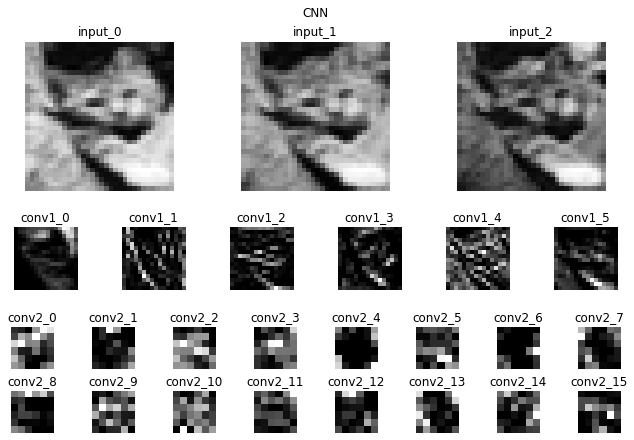

In [76]:
from params import *
from CNN import CNN

model = CNN().to(DEVICE)
model.load_state_dict(torch.load("./model/CNN.ckpt", map_location=DEVICE))
model.eval()
visualize_model(model, image.to(DEVICE), "CNN", "./fig/Vis-CNN.pdf")


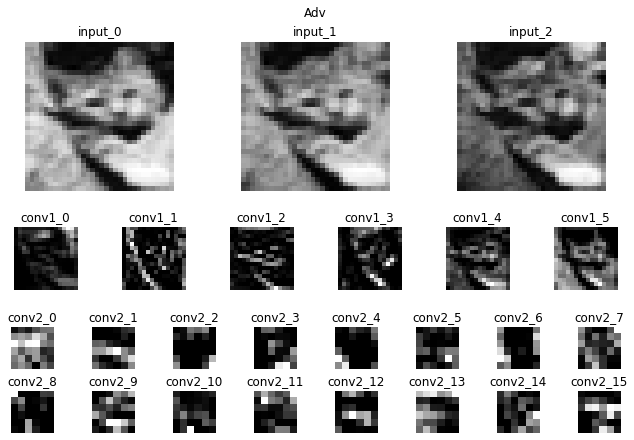

In [88]:
from PGD import PGD
from Adversarial import AdvTrain

model = AdvTrain(CNN(), PGD()).to(DEVICE)
model.load_state_dict(torch.load("./model/Adv.ckpt", map_location=DEVICE))
model.eval()
visualize_model(model.model, image.to(DEVICE), "Adv", "./fig/Vis-Adv.pdf")


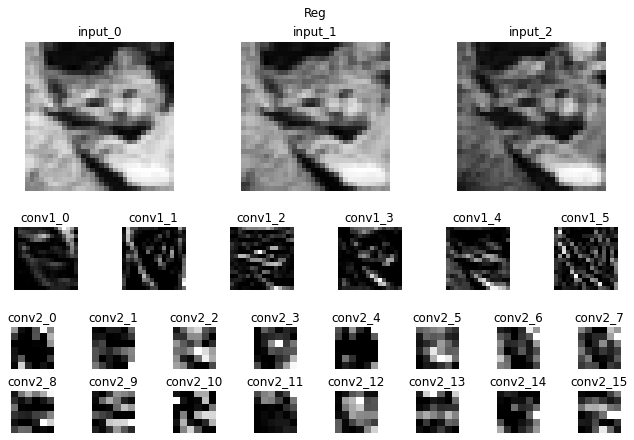

In [78]:
model = CNN().to(DEVICE)
model.load_state_dict(torch.load("./model/Reg.ckpt", map_location=DEVICE))
model.eval()
visualize_model(model, image.to(DEVICE), "Reg", "./fig/Vis-Reg.pdf")


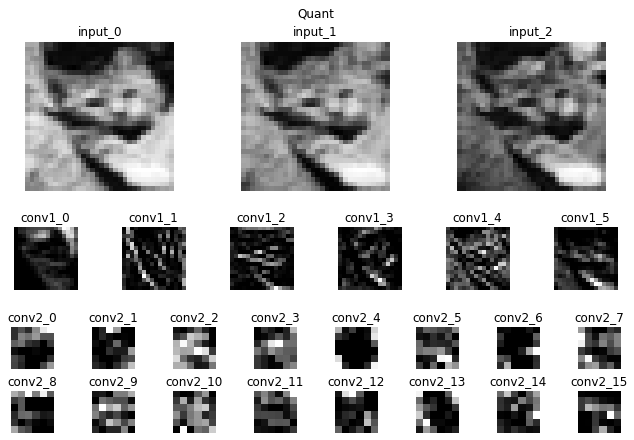

In [79]:
from Quantization import QuantTrain

model = QuantTrain(
    CNN(), QUANT_WEIGHT_BITS, QUANT_WEIGHT_BITS, QUANT_WEIGHT, QUANT_THRESH
).to(DEVICE)
model.load_state_dict(torch.load("./model/Quant.ckpt", map_location=DEVICE))
model.eval()
visualize_model(model.model, image.to(DEVICE), "Quant", "./fig/Vis-Quant.pdf")


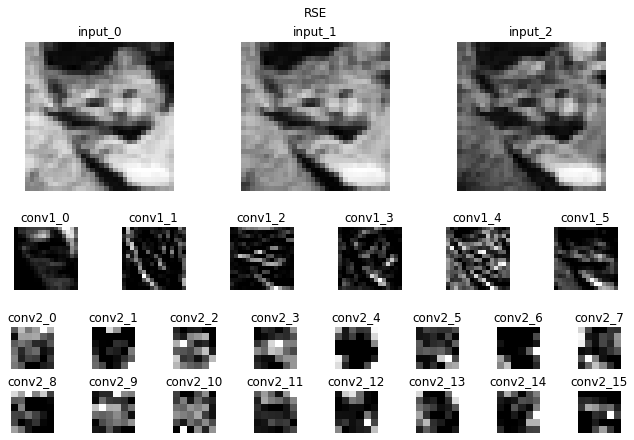

In [80]:
from RandomSelfEnsemble import RSE

model = RSE(CNN(), RSE_INIT, RSE_INNER, RSE_NUM).to(DEVICE)
model.load_state_dict(torch.load("./model/RSE.ckpt", map_location=DEVICE))
model.eval()
visualize_model(model.model, image.to(DEVICE), "RSE", "./fig/Vis-RSE.pdf")


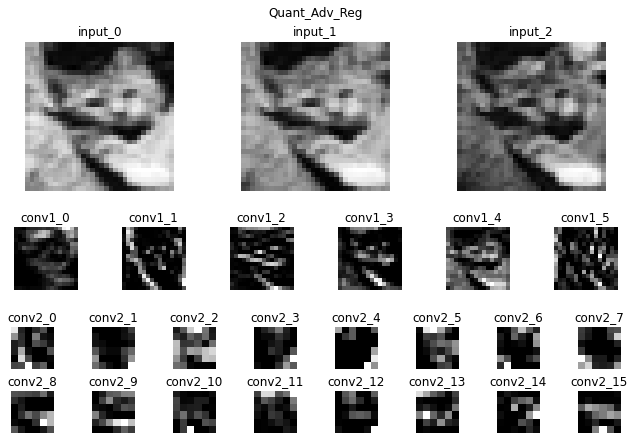

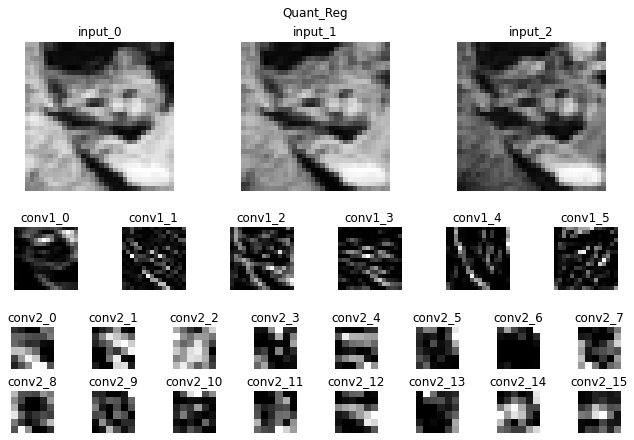

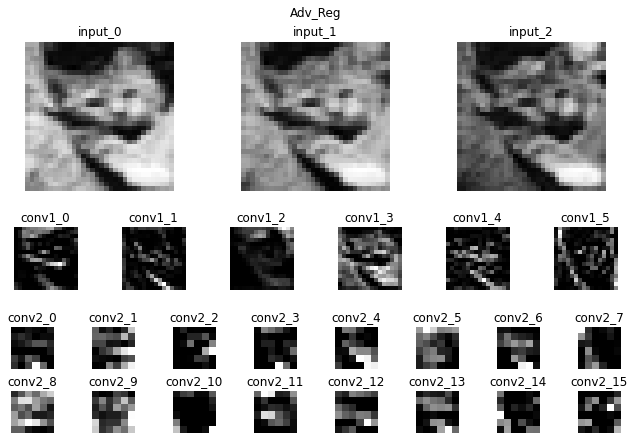

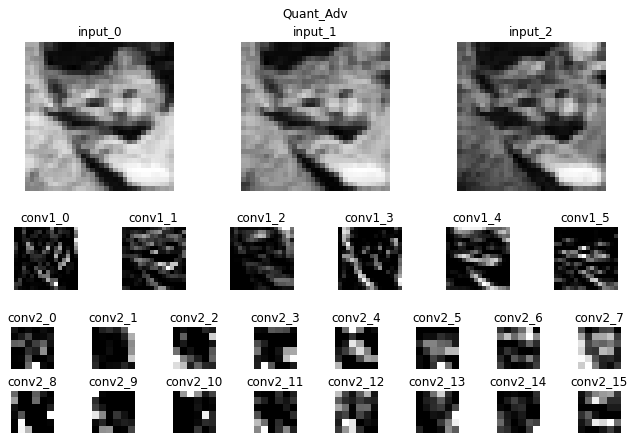

In [87]:
from Combination import CombineTrain

hhps = [
    (True, True, True),
    (False, True, True),
    (True, False, True),
    (True, True, False),
]
for adversarial, quantization, regularization in hhps:
    model = CombineTrain(
        CNN(),
        adversarial,
        ATTACK_EPS,
        ATTACK_ALPHA,
        ATTACK_ITER,
        QUANT_WEIGHT and quantization,
        QUANT_THRESH and quantization,
        QUANT_WEIGHT_BITS,
        QUANT_THRESH_BITS,
    )
    strategy_name = (
        ("Quant_" if quantization else "")
        + ("Adv_" if adversarial else "")
        + ("Reg_" if regularization else "")
    ).strip("_")
    model.load_state_dict(
        torch.load(f"./model/Comb_{strategy_name}_Train.ckpt", map_location=DEVICE)
    )
    model.eval()
    visualize_model(
        model.model.model.model
        if adversarial and quantization
        else model.model
        if not adversarial and not quantization
        else model.model.model,
        image.to(DEVICE),
        f"{strategy_name}",
        f"./fig/Vis-{strategy_name}.pdf",
    )
